## Importing Packages

In [1]:
seal = ['adult_males', 'subadult males', 'adult females', 'juveniles', 'pups']
rgb = [(243,8,5), (244,8,242), (87,46,10), (25,56,176), (38,174,21)]  
cls = [0, 1, 2, 3, 4]
hex = ['#f30805', '#f408f2', '#572e0a', '#1938b0', '#26ae15']

In [2]:
seal2rgb = dict(zip(seal,rgb))
cls2rgb = dict(zip(cls, rgb))
cls2hex = dict(zip(cls, hex))
seal2cls = dict(zip(seal,cls))
cls2seal = dict(zip(cls,seal))
rgb2cls = dict(zip(rgb, cls))

In [3]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

Using cuDNN version 6021 on context None
Mapped name None to device cuda0: GeForce GTX 1070 (0000:01:00.0)
Using Theano backend.


In [4]:
K.image_dim_ordering()

'tf'

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, GlobalAveragePooling2D, Input
from keras.models import Model
from keras import backend as K
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from PIL import  Image
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt

n_classes= 5
batch_size= 4
epochs= 100
image_size= 360
img_sz = (512,512)
model_name= 'cnn_regression_moi'

### Loading file names

In [6]:
trn_ids = pd.read_csv('../IDsTrainingSet.txt')
tst_ids = pd.read_csv('../IDsforBlending.txt')
trn_ids = np.array(trn_ids.columns)
tst_ids = np.array(tst_ids.columns)
ids = np.hstack([trn_ids,tst_ids])
fnames = ['train_images_512x512/'+str(int(i))+'.png' for i in trn_ids]
tnames = ['train_images_512x512/'+str(int(i))+'.png' for i in tst_ids]
names = fnames+tnames

In [7]:
# fnames = glob.glob(frames_path+'*.jpg')
print (fnames[0:3])

['train_images_512x512/1.png', 'train_images_512x512/5.png', 'train_images_512x512/8.png']


In [8]:
# dnames = [dot_path+os.path.basename(fn)[:-4]+'.jpg' for fn in fnames]
print (tnames[0:3])

['train_images_512x512/513.png', 'train_images_512x512/2.png', 'train_images_512x512/516.png']


In [9]:
def open_image(fn): return np.array(Image.open(fn).resize(img_sz, Image.NEAREST))

In [11]:
# training and blending split
trn_imgs = np.stack([open_image(fn) for fn in fnames])
val_imgs = np.stack([open_image(fn) for fn in tnames])
trn_imgs.shape, val_imgs.shape

((657, 512, 512, 3), (250, 512, 512, 3))

In [12]:
# combining both for preprocessing
imgs = np.vstack([trn_imgs,val_imgs])
imgs.shape

(907, 512, 512, 3)

In [13]:
imgs = imgs/255.

In [14]:
mean = imgs.mean() 
std = imgs.std()
mean, std

(0.46482176936529301, 0.18052158503944921)

In [15]:
mean = 0.46482176936529301
std = 0.18052158503944921

In [16]:
imgs-=mean
imgs/=std

In [17]:
imgs = np.asarray(imgs)

## Labels

In [18]:
df= pd.read_csv('train.csv')
y_list=[]
for i in ids: 
    row= df.ix[int(i)] 
    y_row= np.zeros((5))
    y_row[0]= row['adult_males']
    y_row[1]= row['subadult_males']
    y_row[2]= row['adult_females']
    y_row[3]= row['juveniles']
    y_row[4]= row['pups']
    y_list.append(y_row)

y_train= np.asarray(y_list)

/home/alibaba/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [19]:
y_train.shape

(907, 5)

## Generator

In [20]:
class BatchIndices(object):
    def __init__(self, n, bs, shuffle=False):
        self.n,self.bs,self.shuffle = n,bs,shuffle
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.n) 
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0

    def __next__(self):
        with self.lock:
            if self.curr >= self.n: self.reset()
            ni = min(self.bs, self.n-self.curr)
            res = self.idxs[self.curr:self.curr+ni]
            self.curr += ni
            return res

In [ ]:
class segm_generator(object):
    def __init__(self, x, y, bs=64, out_sz=(224,224), train=True):
        self.x, self.y, self.bs, self.train = x,y,bs,train
        self.n, self.ri, self.ci, _ = x.shape
        self.idx_gen = BatchIndices(self.n, bs, train)
        self.ro, self.co = out_sz
#         self.ych = self.y.shape[-1] if len(y.shape)==4 else 1

    def get_slice(self, i,o):
        start = random.randint(0, i-o) if self.train else (i-o)
        return slice(start, start+o)

    def get_item(self, idx):
        condition =True
        while True:
            slice_r = self.get_slice(self.ri, self.ro)
            slice_c = self.get_slice(self.ci, self.co)
            x = self.x[idx, slice_r, slice_c]
#             y = self.y[idx, slice_r, slice_c]
            if self.train and (random.random()>0.5): 
#                 y = y[:,::-1]
                x = x[:,::-1]
            # Modified to create patches with atleast one sea lion
        
        return x, y

    def __next__(self):
        idxs = next(self.idx_gen)
        items = (self.get_item(idx) for idx in idxs)
        xs,ys = zip(*items)
        return np.stack(xs), np.stack(ys)

In [21]:
lrg_sz = (224,224)

## Training

In [21]:
image_size = 512

In [22]:
train_set = imgs[:657]
train_labels = y_train[:657]

test_set = imgs[657:]
test_labels = y_train[657:]

In [23]:
train_set.shape, test_set.shape, train_labels.shape, test_labels.shape

((657, 512, 512, 3), (250, 512, 512, 3), (657, 5), (250, 5))

In [24]:
input_shape = (image_size, image_size,3)
input_shape

(512, 512, 3)

In [29]:
names[4]

'train_images_512x512/13.png'

In [30]:
df[df.train_id==13]

,train_id,adult_males,subadult_males,adult_females,juveniles,pups
13,13,2,5,20,13,0


In [31]:
y_train[4]

array([  2.,   5.,  20.,  13.,   0.])

In [32]:
model = Sequential()

model.add(Conv2D(32, 3, 3, border_mode='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(n_classes, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(GlobalAveragePooling2D())


model.compile(loss=keras.objectives.mean_squared_error,
        optimizer= keras.optimizers.adam(lr=0.01))

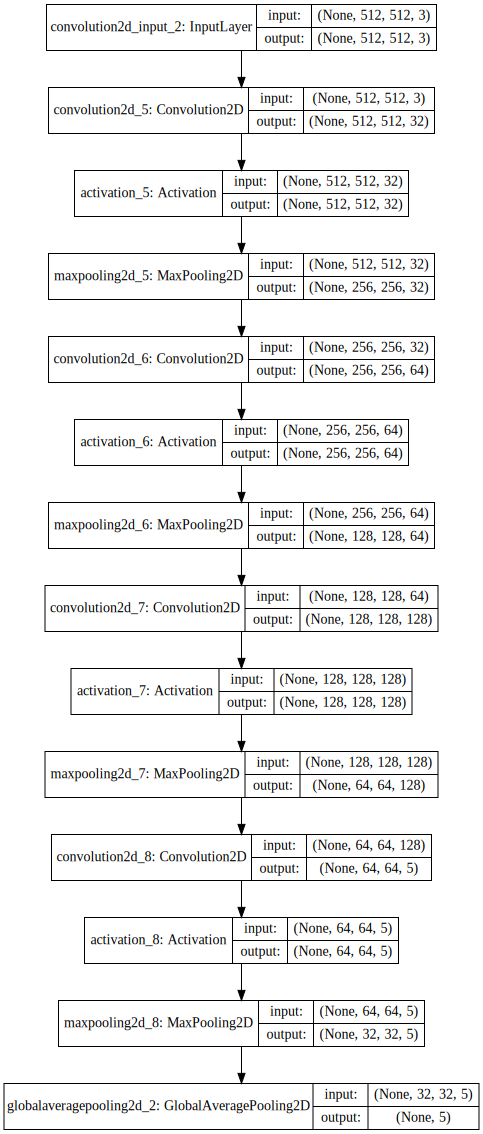

In [33]:
from IPython.display import Image, display, SVG
from keras.utils.visualize_util import model_to_dot

# Show the model in ipython notebook
figure = SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
display(figure)

# Save the model as png file
from keras.utils.visualize_util import plot
plot(model, to_file='model.png', show_shapes=True)

In [34]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback

In [35]:
early_stopping =EarlyStopping(monitor='val_loss', patience=3)
bst_model_path = 'best.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

In [ ]:
datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True)

model.fit_generator(generator=datagen.flow(train_set, train_labels, batch_size=4), samples_per_epoch=len(train_set),nb_epoch=200,verbose=2,
                    validation_data=(test_set, test_labels),nb_val_samples=len(test_set), callbacks=[early_stopping,TQDMNotebookCallback(),model_checkpoint])

Epoch 1/200
79s - loss: 2060.3956 - val_loss: 2670.0188
Epoch 2/200
